In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
from glmtools.io.glm import GLMDataset, fix_event_locations
from glmtools.grid.clipping import QuadMeshSubset, QuadMeshPolySlicer

# Tests using generic geometry

In [2]:
# x = np.arange(5)
# y = np.arange(6)+10

x = np.arange(50)
y = np.arange(60)+10
X,Y=np.meshgrid(x,y)

vals = np.random.rand(X.shape[0]-1, X.shape[1]-1)
print(X.shape, Y.shape, vals.shape)

a_poly = [(.5,12), (1.7+2,13+1), (1.9+2,12.5+1), (.9+2, 11)]

N_polys = 5
polys = np.asarray([a_poly] * N_polys)
# polys += np.random.rand(N_polys,4,2) 
polys += .8*x.shape[0]*np.random.rand(N_polys)[:,None,None]

(60, 50) (60, 50) (59, 49)


In [3]:
print(X.T[:,0])
print(X.max())
print(polys)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
49
[[[ 14.87283918  26.37283918]
  [ 18.07283918  28.37283918]
  [ 18.27283918  27.87283918]
  [ 17.27283918  25.37283918]]

 [[ 29.51792676  41.01792676]
  [ 32.71792676  43.01792676]
  [ 32.91792676  42.51792676]
  [ 31.91792676  40.01792676]]

 [[ 33.5237542   45.0237542 ]
  [ 36.7237542   47.0237542 ]
  [ 36.9237542   46.5237542 ]
  [ 35.9237542   44.0237542 ]]

 [[  7.1071021   18.6071021 ]
  [ 10.3071021   20.6071021 ]
  [ 10.5071021   20.1071021 ]
  [  9.5071021   17.6071021 ]]

 [[ 30.29807605  41.79807605]
  [ 33.49807605  43.79807605]
  [ 33.69807605  43.29807605]
  [ 32.69807605  40.79807605]]]


In [4]:
mesh = QuadMeshSubset(X, Y, n_neighbors=20)

slicer = QuadMeshPolySlicer(mesh)

chopped_polys, poly_areas = slicer.slice(polys)
# print(len(chopped_polys))
# print(chopped_polys[0])



def gen_polys(chopped_polys):
    for (subquads, areas, (x_idxs, y_idxs)), total_area  in zip(chopped_polys, poly_areas):
        quad_fracs = slicer.quad_frac_from_poly_frac_area(
                        areas, total_area, x_idxs, y_idxs)

        for subquad, area, x_idx, y_idx, quad_area in zip(subquads, areas, x_idxs, y_idxs, quad_fracs):
#             print('-------')
#             print('subquad', subquad)
#             print('frac_area, quad_frac_area', area, quad_area)
#             print('idx', x_idx, y_idx)
            yield (subquad, area, (x_idx, y_idx))
        
good_polys = [p for p in gen_polys(chopped_polys)]
# print(good_polys[0:2])

Calculating polygons from mesh ...
    ... constructing search tree ... be patient ...
    ... done.
Polygon only 99.81284867105778 percent covered by quads ...
   ... try increasing n_neighbors.
Polygon only 99.10757385592002 percent covered by quads ...
   ... try increasing n_neighbors.
Polygon only 99.18630284002778 percent covered by quads ...
   ... try increasing n_neighbors.


<IPython.core.display.Javascript object>


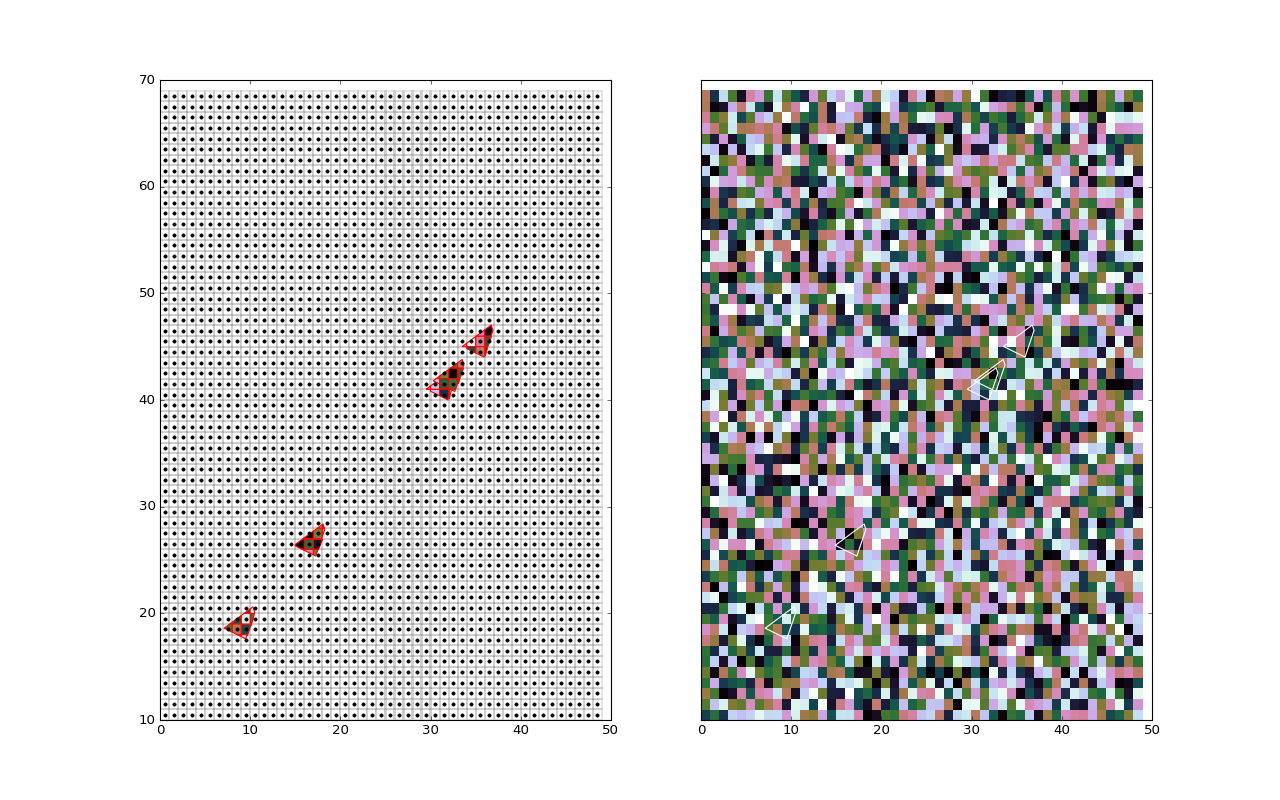

[ 0.89990456  0.55049818  0.6707486   0.9899803   0.34806038  0.55792187
  0.32758265  0.35658044  0.92976944  0.24207837  0.73609235  0.17250987
  0.70044706  0.64482519  0.55352779  0.97120164  0.82853595  0.19795276
  0.1295199   0.2072378   0.62086006  0.4619986   0.39009997  0.7188787
  0.3599778   0.91725383  0.45814539  0.03048014  0.97781271  0.74668412
  0.2626204   0.30866603  0.09545681  0.76030578  0.73197259  0.47948747
  0.63945638  0.7299599   0.8291681   0.10443024  0.1768618   0.63796765
  0.38627832  0.62160188  0.97120164  0.64482519  0.68359023  0.55352779
  0.62086006  0.88025622  0.70044706  0.46668827  0.1295199   0.48680001
  0.19795276]


In [5]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
fig, axs = plt.subplots(1,2, figsize=(16,10), sharex=True, sharey=True)
ax = axs[0]
ax1 = axs[1]

vmin, vmax = 0, 1

# Chopped polys
pm = ax.pcolormesh(X, Y, vals*0, edgecolor='black', alpha=0.1, cmap='cubehelix_r', vmin=vmin, vmax=vmax)
ax.plot(mesh.X_ctr, mesh.Y_ctr, '.k')
patches = [Polygon(p, True) for p, area, ctrs in good_polys]
patch_coll = PatchCollection(patches, edgecolors='red', norm=pm.norm, cmap=pm.cmap, alpha=1.0)
patch_vals = np.asarray([vals[ctrs[0], ctrs[1]] for p, area, ctrs in good_polys])
print(patch_vals)
patch_coll.set_array(patch_vals)
ax.add_collection(patch_coll)

# Original polys
pm1 = ax1.pcolormesh(X,Y, vals, edgecolor='none', alpha=1.0, norm=pm.norm, cmap=pm.cmap)
patches = [Polygon(p, True) for p in polys]
patch_coll = PatchCollection(patches, edgecolors='red', facecolors='none', norm=pm.norm, cmap=pm.cmap, alpha=1.0)
patch_coll.set_array(np.fromiter((0 for p in polys), dtype=float))
ax1.add_collection(patch_coll)

# x0, x1, y0, y1 = X.min(), X.max(), Y.min(), Y.max()

# ax.axis((.4,1.5,10,16))
# ax.axis((5,15,20,30))

In [6]:
for p in polys:
    print(np.asarray(p).mean(axis=0))

[ 22.77317171  32.64817171]
[  9.44611852  19.32111852]
[ 27.4983784  37.3733784]
[ 38.22567464  48.10067464]
[  3.23880266  13.11380266]


In [6]:
nq0, nq1 = mesh.quads.shape[0:2]

for i in range(nq0):
    for j in range(nq1):
        print(mesh.X_ctr[i, j], mesh.Y_ctr[i,j])
        print(mesh.quads[i,j,:,:])

0.5 10.5
[[  0.  10.]
 [  1.  10.]
 [  1.  11.]
 [  0.  11.]]
1.5 10.5
[[  1.  10.]
 [  2.  10.]
 [  2.  11.]
 [  1.  11.]]
2.5 10.5
[[  2.  10.]
 [  3.  10.]
 [  3.  11.]
 [  2.  11.]]
3.5 10.5
[[  3.  10.]
 [  4.  10.]
 [  4.  11.]
 [  3.  11.]]
4.5 10.5
[[  4.  10.]
 [  5.  10.]
 [  5.  11.]
 [  4.  11.]]
5.5 10.5
[[  5.  10.]
 [  6.  10.]
 [  6.  11.]
 [  5.  11.]]
6.5 10.5
[[  6.  10.]
 [  7.  10.]
 [  7.  11.]
 [  6.  11.]]
7.5 10.5
[[  7.  10.]
 [  8.  10.]
 [  8.  11.]
 [  7.  11.]]
8.5 10.5
[[  8.  10.]
 [  9.  10.]
 [  9.  11.]
 [  8.  11.]]
9.5 10.5
[[  9.  10.]
 [ 10.  10.]
 [ 10.  11.]
 [  9.  11.]]
10.5 10.5
[[ 10.  10.]
 [ 11.  10.]
 [ 11.  11.]
 [ 10.  11.]]
11.5 10.5
[[ 11.  10.]
 [ 12.  10.]
 [ 12.  11.]
 [ 11.  11.]]
12.5 10.5
[[ 12.  10.]
 [ 13.  10.]
 [ 13.  11.]
 [ 12.  11.]]
13.5 10.5
[[ 13.  10.]
 [ 14.  10.]
 [ 14.  11.]
 [ 13.  11.]]
14.5 10.5
[[ 14.  10.]
 [ 15.  10.]
 [ 15.  11.]
 [ 14.  11.]]
15.5 10.5
[[ 15.  10.]
 [ 16.  10.]
 [ 16.  11.]
 [ 15.  11.]]
16

19.5 16.5
[[ 19.  16.]
 [ 20.  16.]
 [ 20.  17.]
 [ 19.  17.]]
20.5 16.5
[[ 20.  16.]
 [ 21.  16.]
 [ 21.  17.]
 [ 20.  17.]]
21.5 16.5
[[ 21.  16.]
 [ 22.  16.]
 [ 22.  17.]
 [ 21.  17.]]
22.5 16.5
[[ 22.  16.]
 [ 23.  16.]
 [ 23.  17.]
 [ 22.  17.]]
23.5 16.5
[[ 23.  16.]
 [ 24.  16.]
 [ 24.  17.]
 [ 23.  17.]]
24.5 16.5
[[ 24.  16.]
 [ 25.  16.]
 [ 25.  17.]
 [ 24.  17.]]
25.5 16.5
[[ 25.  16.]
 [ 26.  16.]
 [ 26.  17.]
 [ 25.  17.]]
26.5 16.5
[[ 26.  16.]
 [ 27.  16.]
 [ 27.  17.]
 [ 26.  17.]]
27.5 16.5
[[ 27.  16.]
 [ 28.  16.]
 [ 28.  17.]
 [ 27.  17.]]
28.5 16.5
[[ 28.  16.]
 [ 29.  16.]
 [ 29.  17.]
 [ 28.  17.]]
29.5 16.5
[[ 29.  16.]
 [ 30.  16.]
 [ 30.  17.]
 [ 29.  17.]]
30.5 16.5
[[ 30.  16.]
 [ 31.  16.]
 [ 31.  17.]
 [ 30.  17.]]
31.5 16.5
[[ 31.  16.]
 [ 32.  16.]
 [ 32.  17.]
 [ 31.  17.]]
32.5 16.5
[[ 32.  16.]
 [ 33.  16.]
 [ 33.  17.]
 [ 32.  17.]]
33.5 16.5
[[ 33.  16.]
 [ 34.  16.]
 [ 34.  17.]
 [ 33.  17.]]
34.5 16.5
[[ 34.  16.]
 [ 35.  16.]
 [ 35.  17.]
 [ 34.

44.5 22.5
[[ 44.  22.]
 [ 45.  22.]
 [ 45.  23.]
 [ 44.  23.]]
45.5 22.5
[[ 45.  22.]
 [ 46.  22.]
 [ 46.  23.]
 [ 45.  23.]]
46.5 22.5
[[ 46.  22.]
 [ 47.  22.]
 [ 47.  23.]
 [ 46.  23.]]
47.5 22.5
[[ 47.  22.]
 [ 48.  22.]
 [ 48.  23.]
 [ 47.  23.]]
48.5 22.5
[[ 48.  22.]
 [ 49.  22.]
 [ 49.  23.]
 [ 48.  23.]]
0.5 23.5
[[  0.  23.]
 [  1.  23.]
 [  1.  24.]
 [  0.  24.]]
1.5 23.5
[[  1.  23.]
 [  2.  23.]
 [  2.  24.]
 [  1.  24.]]
2.5 23.5
[[  2.  23.]
 [  3.  23.]
 [  3.  24.]
 [  2.  24.]]
3.5 23.5
[[  3.  23.]
 [  4.  23.]
 [  4.  24.]
 [  3.  24.]]
4.5 23.5
[[  4.  23.]
 [  5.  23.]
 [  5.  24.]
 [  4.  24.]]
5.5 23.5
[[  5.  23.]
 [  6.  23.]
 [  6.  24.]
 [  5.  24.]]
6.5 23.5
[[  6.  23.]
 [  7.  23.]
 [  7.  24.]
 [  6.  24.]]
7.5 23.5
[[  7.  23.]
 [  8.  23.]
 [  8.  24.]
 [  7.  24.]]
8.5 23.5
[[  8.  23.]
 [  9.  23.]
 [  9.  24.]
 [  8.  24.]]
9.5 23.5
[[  9.  23.]
 [ 10.  23.]
 [ 10.  24.]
 [  9.  24.]]
10.5 23.5
[[ 10.  23.]
 [ 11.  23.]
 [ 11.  24.]
 [ 10.  24.]]
11

22.5 29.5
[[ 22.  29.]
 [ 23.  29.]
 [ 23.  30.]
 [ 22.  30.]]
23.5 29.5
[[ 23.  29.]
 [ 24.  29.]
 [ 24.  30.]
 [ 23.  30.]]
24.5 29.5
[[ 24.  29.]
 [ 25.  29.]
 [ 25.  30.]
 [ 24.  30.]]
25.5 29.5
[[ 25.  29.]
 [ 26.  29.]
 [ 26.  30.]
 [ 25.  30.]]
26.5 29.5
[[ 26.  29.]
 [ 27.  29.]
 [ 27.  30.]
 [ 26.  30.]]
27.5 29.5
[[ 27.  29.]
 [ 28.  29.]
 [ 28.  30.]
 [ 27.  30.]]
28.5 29.5
[[ 28.  29.]
 [ 29.  29.]
 [ 29.  30.]
 [ 28.  30.]]
29.5 29.5
[[ 29.  29.]
 [ 30.  29.]
 [ 30.  30.]
 [ 29.  30.]]
30.5 29.5
[[ 30.  29.]
 [ 31.  29.]
 [ 31.  30.]
 [ 30.  30.]]
31.5 29.5
[[ 31.  29.]
 [ 32.  29.]
 [ 32.  30.]
 [ 31.  30.]]
32.5 29.5
[[ 32.  29.]
 [ 33.  29.]
 [ 33.  30.]
 [ 32.  30.]]
33.5 29.5
[[ 33.  29.]
 [ 34.  29.]
 [ 34.  30.]
 [ 33.  30.]]
34.5 29.5
[[ 34.  29.]
 [ 35.  29.]
 [ 35.  30.]
 [ 34.  30.]]
35.5 29.5
[[ 35.  29.]
 [ 36.  29.]
 [ 36.  30.]
 [ 35.  30.]]
36.5 29.5
[[ 36.  29.]
 [ 37.  29.]
 [ 37.  30.]
 [ 36.  30.]]
37.5 29.5
[[ 37.  29.]
 [ 38.  29.]
 [ 38.  30.]
 [ 37.

[[ 18.  36.]
 [ 19.  36.]
 [ 19.  37.]
 [ 18.  37.]]
19.5 36.5
[[ 19.  36.]
 [ 20.  36.]
 [ 20.  37.]
 [ 19.  37.]]
20.5 36.5
[[ 20.  36.]
 [ 21.  36.]
 [ 21.  37.]
 [ 20.  37.]]
21.5 36.5
[[ 21.  36.]
 [ 22.  36.]
 [ 22.  37.]
 [ 21.  37.]]
22.5 36.5
[[ 22.  36.]
 [ 23.  36.]
 [ 23.  37.]
 [ 22.  37.]]
23.5 36.5
[[ 23.  36.]
 [ 24.  36.]
 [ 24.  37.]
 [ 23.  37.]]
24.5 36.5
[[ 24.  36.]
 [ 25.  36.]
 [ 25.  37.]
 [ 24.  37.]]
25.5 36.5
[[ 25.  36.]
 [ 26.  36.]
 [ 26.  37.]
 [ 25.  37.]]
26.5 36.5
[[ 26.  36.]
 [ 27.  36.]
 [ 27.  37.]
 [ 26.  37.]]
27.5 36.5
[[ 27.  36.]
 [ 28.  36.]
 [ 28.  37.]
 [ 27.  37.]]
28.5 36.5
[[ 28.  36.]
 [ 29.  36.]
 [ 29.  37.]
 [ 28.  37.]]
29.5 36.5
[[ 29.  36.]
 [ 30.  36.]
 [ 30.  37.]
 [ 29.  37.]]
30.5 36.5
[[ 30.  36.]
 [ 31.  36.]
 [ 31.  37.]
 [ 30.  37.]]
31.5 36.5
[[ 31.  36.]
 [ 32.  36.]
 [ 32.  37.]
 [ 31.  37.]]
32.5 36.5
[[ 32.  36.]
 [ 33.  36.]
 [ 33.  37.]
 [ 32.  37.]]
33.5 36.5
[[ 33.  36.]
 [ 34.  36.]
 [ 34.  37.]
 [ 33.  37.]]
34

42.5 42.5
[[ 42.  42.]
 [ 43.  42.]
 [ 43.  43.]
 [ 42.  43.]]
43.5 42.5
[[ 43.  42.]
 [ 44.  42.]
 [ 44.  43.]
 [ 43.  43.]]
44.5 42.5
[[ 44.  42.]
 [ 45.  42.]
 [ 45.  43.]
 [ 44.  43.]]
45.5 42.5
[[ 45.  42.]
 [ 46.  42.]
 [ 46.  43.]
 [ 45.  43.]]
46.5 42.5
[[ 46.  42.]
 [ 47.  42.]
 [ 47.  43.]
 [ 46.  43.]]
47.5 42.5
[[ 47.  42.]
 [ 48.  42.]
 [ 48.  43.]
 [ 47.  43.]]
48.5 42.5
[[ 48.  42.]
 [ 49.  42.]
 [ 49.  43.]
 [ 48.  43.]]
0.5 43.5
[[  0.  43.]
 [  1.  43.]
 [  1.  44.]
 [  0.  44.]]
1.5 43.5
[[  1.  43.]
 [  2.  43.]
 [  2.  44.]
 [  1.  44.]]
2.5 43.5
[[  2.  43.]
 [  3.  43.]
 [  3.  44.]
 [  2.  44.]]
3.5 43.5
[[  3.  43.]
 [  4.  43.]
 [  4.  44.]
 [  3.  44.]]
4.5 43.5
[[  4.  43.]
 [  5.  43.]
 [  5.  44.]
 [  4.  44.]]
5.5 43.5
[[  5.  43.]
 [  6.  43.]
 [  6.  44.]
 [  5.  44.]]
6.5 43.5
[[  6.  43.]
 [  7.  43.]
 [  7.  44.]
 [  6.  44.]]
7.5 43.5
[[  7.  43.]
 [  8.  43.]
 [  8.  44.]
 [  7.  44.]]
8.5 43.5
[[  8.  43.]
 [  9.  43.]
 [  9.  44.]
 [  8.  44.]]
9

42.5 49.5
[[ 42.  49.]
 [ 43.  49.]
 [ 43.  50.]
 [ 42.  50.]]
43.5 49.5
[[ 43.  49.]
 [ 44.  49.]
 [ 44.  50.]
 [ 43.  50.]]
44.5 49.5
[[ 44.  49.]
 [ 45.  49.]
 [ 45.  50.]
 [ 44.  50.]]
45.5 49.5
[[ 45.  49.]
 [ 46.  49.]
 [ 46.  50.]
 [ 45.  50.]]
46.5 49.5
[[ 46.  49.]
 [ 47.  49.]
 [ 47.  50.]
 [ 46.  50.]]
47.5 49.5
[[ 47.  49.]
 [ 48.  49.]
 [ 48.  50.]
 [ 47.  50.]]
48.5 49.5
[[ 48.  49.]
 [ 49.  49.]
 [ 49.  50.]
 [ 48.  50.]]
0.5 50.5
[[  0.  50.]
 [  1.  50.]
 [  1.  51.]
 [  0.  51.]]
1.5 50.5
[[  1.  50.]
 [  2.  50.]
 [  2.  51.]
 [  1.  51.]]
2.5 50.5
[[  2.  50.]
 [  3.  50.]
 [  3.  51.]
 [  2.  51.]]
3.5 50.5
[[  3.  50.]
 [  4.  50.]
 [  4.  51.]
 [  3.  51.]]
4.5 50.5
[[  4.  50.]
 [  5.  50.]
 [  5.  51.]
 [  4.  51.]]
5.5 50.5
[[  5.  50.]
 [  6.  50.]
 [  6.  51.]
 [  5.  51.]]
6.5 50.5
[[  6.  50.]
 [  7.  50.]
 [  7.  51.]
 [  6.  51.]]
7.5 50.5
[[  7.  50.]
 [  8.  50.]
 [  8.  51.]
 [  7.  51.]]
8.5 50.5
[[  8.  50.]
 [  9.  50.]
 [  9.  51.]
 [  8.  51.]]
9

15.5 56.5
[[ 15.  56.]
 [ 16.  56.]
 [ 16.  57.]
 [ 15.  57.]]
16.5 56.5
[[ 16.  56.]
 [ 17.  56.]
 [ 17.  57.]
 [ 16.  57.]]
17.5 56.5
[[ 17.  56.]
 [ 18.  56.]
 [ 18.  57.]
 [ 17.  57.]]
18.5 56.5
[[ 18.  56.]
 [ 19.  56.]
 [ 19.  57.]
 [ 18.  57.]]
19.5 56.5
[[ 19.  56.]
 [ 20.  56.]
 [ 20.  57.]
 [ 19.  57.]]
20.5 56.5
[[ 20.  56.]
 [ 21.  56.]
 [ 21.  57.]
 [ 20.  57.]]
21.5 56.5
[[ 21.  56.]
 [ 22.  56.]
 [ 22.  57.]
 [ 21.  57.]]
22.5 56.5
[[ 22.  56.]
 [ 23.  56.]
 [ 23.  57.]
 [ 22.  57.]]
23.5 56.5
[[ 23.  56.]
 [ 24.  56.]
 [ 24.  57.]
 [ 23.  57.]]
24.5 56.5
[[ 24.  56.]
 [ 25.  56.]
 [ 25.  57.]
 [ 24.  57.]]
25.5 56.5
[[ 25.  56.]
 [ 26.  56.]
 [ 26.  57.]
 [ 25.  57.]]
26.5 56.5
[[ 26.  56.]
 [ 27.  56.]
 [ 27.  57.]
 [ 26.  57.]]
27.5 56.5
[[ 27.  56.]
 [ 28.  56.]
 [ 28.  57.]
 [ 27.  57.]]
28.5 56.5
[[ 28.  56.]
 [ 29.  56.]
 [ 29.  57.]
 [ 28.  57.]]
29.5 56.5
[[ 29.  56.]
 [ 30.  56.]
 [ 30.  57.]
 [ 29.  57.]]
30.5 56.5
[[ 30.  56.]
 [ 31.  56.]
 [ 31.  57.]
 [ 30.

[[  2.  63.]
 [  3.  63.]
 [  3.  64.]
 [  2.  64.]]
3.5 63.5
[[  3.  63.]
 [  4.  63.]
 [  4.  64.]
 [  3.  64.]]
4.5 63.5
[[  4.  63.]
 [  5.  63.]
 [  5.  64.]
 [  4.  64.]]
5.5 63.5
[[  5.  63.]
 [  6.  63.]
 [  6.  64.]
 [  5.  64.]]
6.5 63.5
[[  6.  63.]
 [  7.  63.]
 [  7.  64.]
 [  6.  64.]]
7.5 63.5
[[  7.  63.]
 [  8.  63.]
 [  8.  64.]
 [  7.  64.]]
8.5 63.5
[[  8.  63.]
 [  9.  63.]
 [  9.  64.]
 [  8.  64.]]
9.5 63.5
[[  9.  63.]
 [ 10.  63.]
 [ 10.  64.]
 [  9.  64.]]
10.5 63.5
[[ 10.  63.]
 [ 11.  63.]
 [ 11.  64.]
 [ 10.  64.]]
11.5 63.5
[[ 11.  63.]
 [ 12.  63.]
 [ 12.  64.]
 [ 11.  64.]]
12.5 63.5
[[ 12.  63.]
 [ 13.  63.]
 [ 13.  64.]
 [ 12.  64.]]
13.5 63.5
[[ 13.  63.]
 [ 14.  63.]
 [ 14.  64.]
 [ 13.  64.]]
14.5 63.5
[[ 14.  63.]
 [ 15.  63.]
 [ 15.  64.]
 [ 14.  64.]]
15.5 63.5
[[ 15.  63.]
 [ 16.  63.]
 [ 16.  64.]
 [ 15.  64.]]
16.5 63.5
[[ 16.  63.]
 [ 17.  63.]
 [ 17.  64.]
 [ 16.  64.]]
17.5 63.5
[[ 17.  63.]
 [ 18.  63.]
 [ 18.  64.]
 [ 17.  64.]]
18.5 63.5

# Tests using layered polygons

Want to union all event polygons to generate a master polygon (possibly disjoint) before slicing.

In [7]:
x = np.arange(10)
y = np.arange(10)+10
X,Y=np.meshgrid(x,y)

vals = np.random.rand(X.shape[0]-1, X.shape[1]-1)
print(X.shape, Y.shape, vals.shape)

a_poly = [(.5,12), (1.7+2,13+1), (1.9+2,12.5+1), (.9+2, 11)]

N_polys = 5
polys = np.asarray([a_poly] * N_polys)

# Shift x coordinate for each polygon successively farther right
x_shift = 0.5
polys[:,:,0] += x_shift*np.arange(polys.shape[0])[:, None]

# Move the last two up to separate them, but just barely
y_shift = 2.95
polys[-2:,:,1] += y_shift

# print(polys.shape)
# polys=polys[-2:]

(10, 10) (10, 10) (9, 9)


In [8]:
# import pyclipper
# from pyclipper import Pyclipper, PolyTreeToPaths, ClosedPathsFromPolyTree, scale_to_clipper, scale_from_clipper

# def clip_polys_by_one_poly(polys, p, scale=True):
#     pc = pyclipper.Pyclipper()
#     open_path = False
#     closed_path = True

#     if scale:
#         polys = scale_to_clipper(polys)
#         p = scale_to_clipper(p)

#     results=[]
#     for q in polys:
#         pc.AddPath(q, pyclipper.PT_SUBJECT, closed_path)
#         pc.AddPath(p, pyclipper.PT_CLIP, closed_path)
#         clip_polys = pc.Execute(clip_type=pyclipper.CT_INTERSECTION)
#         if scale:
#             clip_polys = scale_from_clipper(clip_polys)
#         results.append(clip_polys) 
#         pc.Clear()
#     return results


# def join_polys(polys, scale=True):
#     pc = pyclipper.Pyclipper()
#     open_path = False
#     closed_path = True

#     if scale:
#         polys = scale_to_clipper(polys)

#     results=[]
# #     for q in polys:
# #         pc.AddPath(q, pyclipper.PT_SUBJECT, closed_path)
#     pc.AddPaths(polys, pyclipper.PT_SUBJECT, closed_path)
#     clip_polys = pc.Execute(pyclipper.CT_UNION, pyclipper.PFT_NONZERO, pyclipper.PFT_NONZERO)
#     if scale:
#         clip_polys = scale_from_clipper(clip_polys)
#     results.extend([cp for cp in clip_polys]) 
#     pc.Clear()
#     return results
from glmtools.grid.clipping import join_polys

jpolys = join_polys(polys)
print(jpolys)
jpolys = [np.asarray(p).squeeze() for p in jpolys]
print(jpolys)
print(jpolys[0].shape)



[[[5.899999999906868, 16.449999999720603], [5.699999999720603, 16.949999999720603], [5.2999999998137355, 16.699999999720603], [5.199999999720603, 16.949999999720603], [2.0, 14.949999999720603], [4.399999999906868, 13.949999999720603], [4.471428571268916, 14.128571428358555], [4.899999999906868, 13.949999999720603]], [[4.899999999906868, 13.5], [4.699999999720603, 14.0], [4.2999999998137355, 13.75], [4.199999999720603, 14.0], [3.7999999998137355, 13.75], [3.6999999997206032, 14.0], [0.5, 12.0], [2.8999999999068677, 11.0], [2.971428571268916, 11.178571428637952], [3.3999999999068677, 11.0], [3.471428571268916, 11.178571428637952], [3.8999999999068677, 11.0]]]
[array([[  5.9       ,  16.45      ],
       [  5.7       ,  16.95      ],
       [  5.3       ,  16.7       ],
       [  5.2       ,  16.95      ],
       [  2.        ,  14.95      ],
       [  4.4       ,  13.95      ],
       [  4.47142857,  14.12857143],
       [  4.9       ,  13.95      ]]), array([[  4.9       ,  13.5       ]

In [9]:
mesh = QuadMeshSubset(X, Y, n_neighbors=50)

slicer = QuadMeshPolySlicer(mesh)

chopped_polys, poly_areas = slicer.slice(jpolys)
# print(chopped_polys)

def gen_polys(chopped_polys):
    for (subquads, areas, (x_idxs, y_idxs)), total_area  in zip(chopped_polys, poly_areas):
        quad_fracs = slicer.quad_frac_from_poly_frac_area(
                        areas, total_area, x_idxs, y_idxs)

        for subquad, area, x_idx, y_idx, quad_area in zip(subquads, areas, x_idxs, y_idxs, quad_fracs):
#             print('-------')
#             print('subquad', subquad)
#             print('frac_area, quad_frac_area', area, quad_area)
#             print('idx', x_idx, y_idx)
            yield (subquad, area, (x_idx, y_idx))
        
good_polys = [p for p in gen_polys(chopped_polys)]

Calculating polygons from mesh ...
    ... constructing search tree ... be patient ...
    ... done.


<IPython.core.display.Javascript object>


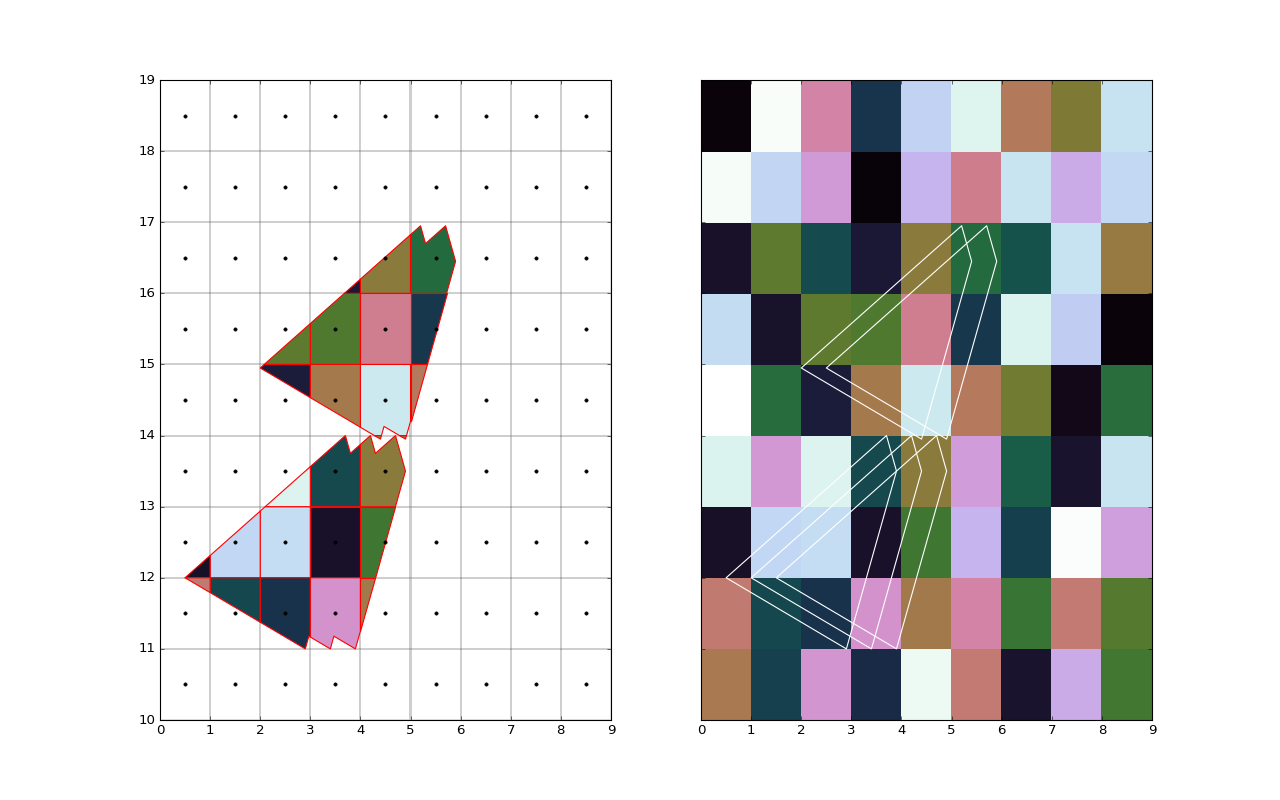

In [10]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
fig, axs = plt.subplots(1,2, figsize=(16,10), sharex=True, sharey=True)
ax = axs[0]
ax1 = axs[1]

vmin, vmax = 0, 1

# Chopped polys
pm = ax.pcolormesh(X, Y, vals*0, edgecolor='black', alpha=0.1, cmap='cubehelix_r', vmin=vmin, vmax=vmax)
ax.plot(mesh.X_ctr, mesh.Y_ctr, '.k')
patches = [Polygon(p, True) for p, area, ctrs in good_polys]
patch_coll = PatchCollection(patches, edgecolors='red', norm=pm.norm, cmap=pm.cmap, alpha=1.0)
patch_vals = np.asarray([vals[ctrs[0], ctrs[1]] for p, area, ctrs in good_polys])
patch_coll.set_array(patch_vals)
ax.add_collection(patch_coll)

# Original polys
pm1 = ax1.pcolormesh(X,Y, vals, edgecolor='none', alpha=1.0, norm=pm.norm, cmap=pm.cmap)
patches = [Polygon(p, True) for p in polys]
patch_coll = PatchCollection(patches, edgecolors='red', facecolors='none', norm=pm.norm, cmap=pm.cmap, alpha=1.0)
patch_coll.set_array(np.fromiter((0 for p in polys), dtype=float))
ax1.add_collection(patch_coll)

# x0, x1, y0, y1 = X.min(), X.max(), Y.min(), Y.max()

# ax.axis((.4,1.5,10,16))
# ax.axis((5,15,20,30))

In [50]:
pc1 = pyclipper.Pyclipper()
pc1.Execute?

In [18]:
a = np.asarray([4, 5, 6, 8, 1, 2])
r = np.asarray([2, 1, 0, 3, 1, 2])
np.repeat(a,r)

array([4, 4, 5, 8, 8, 8, 1, 2, 2])

In [19]:
b = []
res = []
res.extend([v for v in a])
print(res)

In [21]:
res.extend([v for v in b])

In [22]:
res

[4, 5, 6, 8, 1, 2]

In [23]:
len(b)

0

In [ ]:
split